In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

In [13]:
#Reading the dataset using pandas
dataset= pd.read_csv('/content/housing.csv')
dataset = dataset.dropna()
#print first 10 rows of the dataset
print("First 10 rows:")
dataset.head(10)



First 10 rows:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


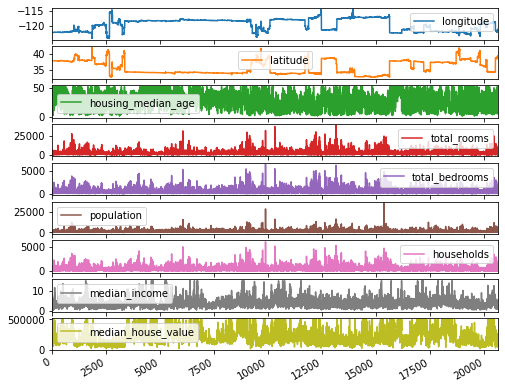

In [14]:
#Data Visualization
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,7)
ax=dataset.plot(subplots=True)

In [0]:
Y= dataset['median_house_value']
X= dataset.loc[:,'longitude':'median_income']

In [0]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=2003)
x_train_np=x_train.to_numpy()
y_train_np=y_train.to_numpy()
x_test_np=x_test.to_numpy()
y_test_np=y_test.to_numpy()

In [0]:
import torch
from torch.nn import Conv1d
from torch.nn import MaxPool1d
from torch.nn import Flatten
from torch.nn import Linear
from torch.nn.functional import relu
from torch.utils.data import DataLoader,TensorDataset

In [0]:
class CnnRegressor(torch.nn.Module):
  def __init__(self,batch_size,inputs,outputs):
    super(CnnRegressor,self).__init__()
    self.batch_size=batch_size
    self.inputs=inputs
    self.outputs=outputs
    
    self.input_layer =Conv1d(inputs,batch_size,kernel_size,1)
    self.max_pooling_layer1 = MaxPool1d(1)
    self.conv_layer1=Conv1d(batch_size,64,kernel_size,1)
    self.max_pooling_layer2 = MaxPool1d(1)
    self.conv_layer2=Conv1d(batch_size,64,kernel_size,1)
    self.flatten_layer=Flatten()
    self.linear_layer=Linear(64,128)
    
    self.output_layer=Linear(128,outputs)


  def feed(self,input):
    input=input.reshape((self.batch_size,self.inputs,1))
    output=relu(self.input_layer(input))
    output=self.max_pooling_layer1(output)
    output=relu(self.conv_layer1(output))
    output=self.max_pooling_layer2(output)
    output=relu(self.conv_layer2(output))
    output=self.flatten_layer(output)
    output=self.linear_layer(output)
    
    output=self.output_layer(output)
    return output

In [19]:
from torch.optim import SGD
from torch.optim import Adadelta,Adamax,Adagrad,Adam
from torch.nn import L1Loss
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

     |████████████████████████████████| 112kB 23.0MB/s 


In [20]:
batch_size=64
kernel_size=1
model=CnnRegressor(batch_size,X.shape[1],1)
print(model.cuda())

CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer1): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer2): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=64, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)


In [0]:
def model_loss(model,dataset,train=False,optimizer=None):
  performance=L1Loss()
  score_metric=R2Score()
  avg_loss=0
  avg_score=0
  count=0
  for input,output in iter(dataset):
    predictions=model.feed(input)
    loss=performance(predictions,output)
    score_metric.update([predictions,output])
    score=score_metric.compute()
    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    avg_loss += loss.item()
    avg_score += score
    count+=1
  return avg_loss/count , avg_score/count

In [27]:
epochs=100
#optimizer = SGD(model.parameters(),lr=1e-5)
optimizer= Adagrad(model.parameters())
inputs=torch.from_numpy(x_train_np).cuda().float()
outputs=torch.from_numpy(y_train_np).reshape(y_train_np.shape[0],1).cuda().float()
tensor = TensorDataset(inputs,outputs)
loader=DataLoader(tensor,batch_size,shuffle=False,drop_last=True)

for epoch in range(epochs):
  avg_loss,avg_r2_score=model_loss(model,loader,train=True,optimizer=optimizer)

  print ("Epoch:" + str(epoch+1) + "\n\tLoss=" + str(avg_loss)+"\n\tR^2 Score= "+ str(avg_r2_score))

Epoch:1
	Loss=69326.71892516816
	R^2 Score= -3.6851862010071734
Epoch:2
	Loss=56100.20133828475
	R^2 Score= 0.5490753208783774
Epoch:3
	Loss=54000.725266255606
	R^2 Score= 0.5858024413263302
Epoch:4
	Loss=52818.72608954596
	R^2 Score= 0.6033749173142082
Epoch:5
	Loss=51925.85932244955
	R^2 Score= 0.6103339423909285
Epoch:6
	Loss=51371.53224845852
	R^2 Score= 0.6179604778747765
Epoch:7
	Loss=51077.82339545964
	R^2 Score= 0.618677185634638
Epoch:8
	Loss=50459.73761561099
	R^2 Score= 0.6240766516415366
Epoch:9
	Loss=50274.86636420964
	R^2 Score= 0.6269524363883942
Epoch:10
	Loss=50112.18030058857
	R^2 Score= 0.6309398643193566
Epoch:11
	Loss=49798.723006586326
	R^2 Score= 0.6337494486126372
Epoch:12
	Loss=49673.28347463565
	R^2 Score= 0.6349840368575427
Epoch:13
	Loss=49611.75679652466
	R^2 Score= 0.6366134440014877
Epoch:14
	Loss=49312.49180213005
	R^2 Score= 0.6422716302795678
Epoch:15
	Loss=49315.05559837444
	R^2 Score= 0.641939418858194
Epoch:16
	Loss=49162.19172155269
	R^2 Score= 0.6

In [23]:
inputs=torch.from_numpy(x_test_np).cuda().float()
outputs=torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()
tensor=TensorDataset(inputs,outputs)
loader=DataLoader(tensor,batch_size,shuffle=True,drop_last=True)
avg_loss, avg_r2_score= model_loss(model,loader)
print("L1_Loss:" + str(avg_loss))
print("R^2 score:" + str(avg_r2_score))

L1_Loss:55834.89568256579
R^2 score:0.53912337353544


In [28]:
torch.save(model, '1111385_1dconv_reg.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CnnRegressor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
